In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [0]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

<Figure size 432x288 with 0 Axes>

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


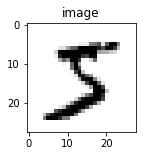

图像数据形状和对应数据为： (28, 28)
图像标签形状和对应数据为： (1,) [5]

打印第一个batch的第一个图像，对应标签数字为[5]


In [2]:
import paddle
from paddle.nn import Linear 
import paddle.nn.functional as F
import os
import numpy as np 
import matplotlib.pyplot as plt 

train_dataset = paddle.vision.datasets.MNIST(mode='train')
train_data0 = np.array(train_dataset[0][0])
train_label_0= np.array(train_dataset[0][1])
plt.figure("Image")
plt.figure(figsize=(2,2))
plt.imshow(train_data0,cmap=plt.cm.binary)
plt.axis('on')
plt.title('image')
plt.show()

print("图像数据形状和对应数据为：",train_data0.shape)
print("图像标签形状和对应数据为：",train_label_0.shape,train_label_0)
print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(train_label_0))



In [10]:
from paddle.vision.transforms import Compose, Normalize
import paddle
import paddle.nn.functional as F
import numpy as np 
from paddle.metric import Accuracy
import random
from visualdl import LogWriter

log_writer=LogWriter("./data/log/train") #log记录器

transform = Compose([Normalize(mean=[127.5],
                               std=[127.5],
                               data_format='CHW')])
# 使用transform对数据集做归一化
print('download training data and load training data')
#读取训练集 测试集数据
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('load finished')


class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)
    #前馈网络
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

model = paddle.Model(LeNet())   # 封装模型
# optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()) # adam优化器

# 配置模型
# model.prepare(
#     optim,
#     paddle.nn.CrossEntropyLoss(),
#     Accuracy()
#     )
# # 训练模型
# model.fit(train_dataset,
#         epochs=2,
#         batch_size=64,
#         verbose=1
#         )
# #评估
# model.evaluate(test_dataset, batch_size=64, verbose=1)

#训练
def train(model,Batch_size=64):
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
    model.train()
    iterator = 0
    epochs = 5
    total_steps = (int(50000//Batch_size)+1)*epochs
    lr = paddle.optimizer.lr.PolynomialDecay(learning_rate=0.01,decay_steps=total_steps,end_lr=0.001)
    optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    # 用Adam作为优化函数
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = F.cross_entropy(predicts, y_data)
            # 计算损失
            acc = paddle.metric.accuracy(predicts, y_data)
            loss.backward()
            if batch_id % 200 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
                log_writer.add_scalar(tag='acc',step=iterator,value=acc.numpy())
                log_writer.add_scalar(tag='loss',step=iterator,value=loss.numpy())
                iterator+=200
            optim.step()
            optim.clear_grad()
        paddle.save(model.state_dict(),'./data/checkpoint/mnist_epoch{}'.format(epoch)+'.pdparams')
        paddle.save(optim.state_dict(),'./data/checkpoint/mnist_epoch{}'.format(epoch)+'.pdopt')


#测试
def test(model):
    # 加载测试数据集
    test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
    model.eval()
    batch_size = 64
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = F.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        if batch_id % 20 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))

#随机抽取100张图片进行测试
def random_test(model,num=100):
    # select_id = random.sample(range(1, 10000), 100) #生成一百张测试图片的下标
    test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        label = data[1]
    predicts = model(x_data)
    #返回正确率
    acc = paddle.metric.accuracy(predicts, label)
    print("正确率为：{}".format(acc.numpy()))

    
    
#调用模型
model = LeNet()
train(model)
test(model)
random_test(model)





download training data and load training data
